In [36]:
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random
import math

import tensorflow as tf
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
from sklearn.metrics import confusion_matrix

from tensorflow.keras.applications import VGG16, MobileNet
from keras.applications.vgg16 import preprocess_input

In [37]:
image_size = (224, 224)

train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [38]:
default_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
augmentation_datagen = ImageDataGenerator(rescale=1./255, 
                                          rotation_range=20,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest') 

In [40]:
train_data = augmentation_datagen.flow_from_directory(train_path,
                                                      target_size=image_size)

Found 43622 images belonging to 300 classes.


In [41]:
validation_data = default_datagen.flow_from_directory(valid_path,
                                                      target_size=image_size)

Found 1500 images belonging to 300 classes.


In [42]:
test_data = default_datagen.flow_from_directory(test_path, 
                                                target_size=image_size)

Found 1500 images belonging to 300 classes.


Found 43622 files belonging to 300 classes.


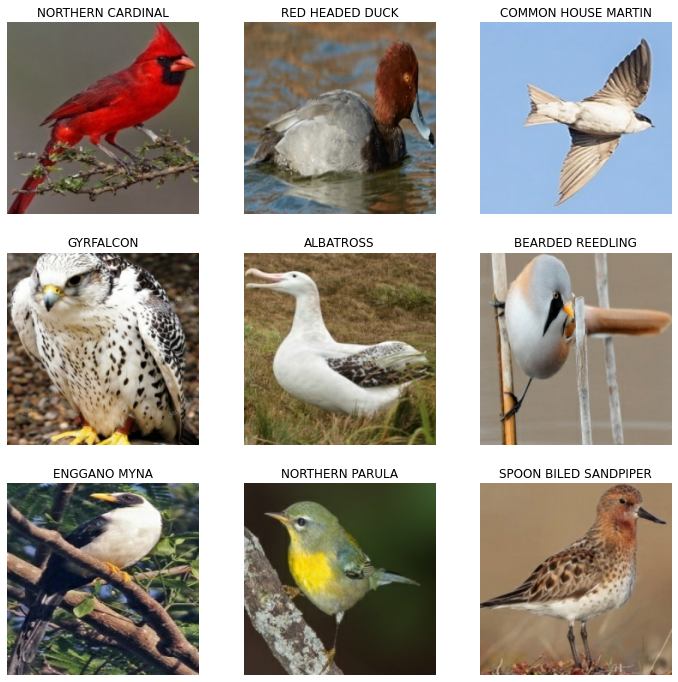

In [43]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_path)
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [44]:
base_mobilenet = MobileNet(weights = 'imagenet',
                           include_top = False,
                           input_shape = (224,224,3))

In [45]:
base_mobilenet.trainable = False 

In [46]:
model = Sequential()
model.add(base_mobilenet)
model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(300)) 
model.add(Activation('softmax'))

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 activation_4 (Activation)   (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 300)               15053100  
                                                                 
 activation_5 (Activation)   (None, 300)               0         
                                                                 
Total params: 18,281,964
Trainable params: 15,053,100
Non-trainable params: 3,228,864
__________________________________

In [48]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001,
                              momentum=0.6,
                              nesterov=True)

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [49]:
history = model.fit(
    train_data, 
    steps_per_epoch = 600, 
    epochs = 12,
    validation_data = validation_data,
    validation_steps = 32,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy',
                             patience=3,
                             restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.7,
                                 patience=2,
                                 verbose=1)]
) 

Epoch 1/12
600/600 [==============================] - 784s 1s/step - loss: 3.7917 - accuracy: 0.3422 - val_loss: 1.0753 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 2/12
600/600 [==============================] - 691s 1s/step - loss: 1.6669 - accuracy: 0.6360 - val_loss: 0.6864 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 3/12
600/600 [==============================] - 593s 988ms/step - loss: 1.2621 - accuracy: 0.7161 - val_loss: 0.5274 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/12
600/600 [==============================] - 547s 911ms/step - loss: 1.0572 - accuracy: 0.7630 - val_loss: 0.4502 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 5/12
600/600 [==============================] - 528s 880ms/step - loss: 0.9436 - accuracy: 0.7843 - val_loss: 0.4492 - val_accuracy: 0.8955 - lr: 0.0010
Epoch 6/12
600/600 [==============================] - 550s 916ms/step - loss: 0.8338 - accuracy: 0.8080 - val_loss: 0.3724 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 7/12
600/600 [==============================] 

In [50]:
model.evaluate(test_data)

47/47 [==============================] - 33s 694ms/step - loss: 0.2537 - accuracy: 0.9420


[0.25366419553756714, 0.9419999718666077]

In [51]:
model.save('model.h5')